In [1]:
from collections import Counter
from pathlib import Path
import random

import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt

from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.transforms import RandomApply, RandomChoice, Grayscale, ColorJitter

from data import CaptchaDataset

In [2]:
train_dir = Path('train')
test_dir = Path('test')

In [3]:
assert train_dir.is_dir()
train_paths = list(p for p in train_dir.glob('*.png'))

In [4]:
assert test_dir.is_dir()
test_paths = list(p for p in test_dir.glob('*.png'))

In [5]:
assert len(train_paths) == len(list(train_dir.iterdir()))
assert len(test_paths) == len(list(test_dir.iterdir()))

dirs contain images only and all images have same png format

In [6]:
print('Train set contains {} images'.format(len(train_paths)))
print('Test set contains {} images'.format(len(test_paths)))

Train set contains 562 images
Test set contains 321 images


In [7]:
train_labels = [p.stem for p in train_paths]

In [8]:
def image_props(path):
    im = Image.open(path)
    return im.size[1], im.size[0], im.mode,

In [9]:
train_props = [image_props(p) for p in train_paths]

In [10]:
heights, widths, modes = zip(*train_props)

In [11]:
[
    Counter(heights),
    Counter(widths),
    Counter(modes),
]

[Counter({150: 562}), Counter({330: 562}), Counter({'RGB': 562})]

all images in train set have the same height, width
and number of channels

dataset consists of colored and grayscale images

images have background with the same pattern, sometimes it's colored too

for each image data placed on a smaller rectangle inside the image

also all images seem to have first grid row unobstructed by letters below

In [12]:
path = Path('train/1A2D4.png')
assert path.is_file()
img = Image.open(path)
img = np.array(img)

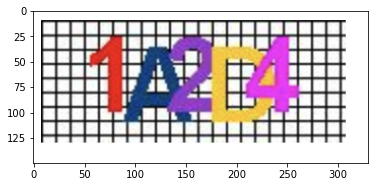

In [13]:
plt.imshow(img)

all images seem to have 5 letter phrase written, but some labels are wrong

for example, D780.png has 'D7080' written

shall filter this labels in dataset

also some labels are written in lowercase, shall fix this too

In [14]:
wrong_labels = [l for l in train_labels if len(l) < 5]

In [15]:
print('From {} train labels {} are wrong'.format(len(train_labels), len(wrong_labels)))

From 562 train labels 3 are wrong


In [16]:
print(wrong_labels)

['D780', 'ec5f', '5A4B']


test CaptchaDataset class and calc mean and std to center and standardize training data

In [17]:
train_ratio = 0.8
height = 150
width = 330

# train set containts only 5-letter labels
train_paths = [p for p in train_paths if len(p.stem) == 5]

seed = 1
random.seed(seed)
random.shuffle(train_paths)
assert 0 < train_ratio < 1
train_split = int(len(train_paths) * train_ratio)
train_paths, valid_paths = train_paths[:train_split], train_paths[train_split:]

train_transform = Compose([
    Resize(size=(height, width)),
    ToTensor(),
])

dataset = CaptchaDataset(train_paths, with_labels=True, preload=True, transform=train_transform)

In [18]:
train_images = torch.stack([d[0] for d in dataset])

In [19]:
train_images.shape

torch.Size([447, 3, 150, 330])

In [20]:
train_images.min(), train_images.max(), train_images.dtype

(tensor(0.), tensor(1.), torch.float32)

In [21]:
mean = train_images.mean(dim=[0, 2, 3])
mean

tensor([0.6699, 0.7106, 0.7476])

In [22]:
std = train_images.std(dim=[0, 2, 3])
std

tensor([0.3723, 0.3575, 0.3259])

In [23]:
height = 150
width = 330
# tensor([0.6699, 0.7106, 0.7476])
# tensor([0.3723, 0.3575, 0.3259])
mean = (0.6699, 0.7106, 0.7476)
std = (0.3723, 0.3575, 0.3259)

train_transform = Compose([
    Resize(size=(height, width)),
    ToTensor(),
    Normalize(mean, std, inplace=True),
])

dataset = CaptchaDataset(train_paths, with_labels=True, preload=True, transform=train_transform)

In [24]:
train_images = torch.stack([d[0] for d in dataset])

In [25]:
train_images.shape

torch.Size([447, 3, 150, 330])

In [26]:
train_images.min(), train_images.max(), train_images.dtype

(tensor(-2.2940), tensor(0.8867), torch.float32)

In [27]:
train_images.mean([0, 2, 3])

tensor([-8.5754e-05,  1.3501e-04,  3.0856e-05])

In [28]:
train_images.std([0, 2, 3])

tensor([0.9999, 1.0000, 1.0002])

In [29]:
def show_image(image, l=None):
    image = np.array(image.permute(1, 2, 0).cpu())
    image = image - np.min(image, axis=(0, 1))
    image = image / np.ptp(image, axis=(0, 1)) * 255
    image = image.astype('uint8')
    image = Image.fromarray(image)
    text = ''.join(dataset.itos(s.item()) for s in l)
    print(text)
    image.show(title=text)

In [30]:
idx = random.randint(0, len(dataset))
img, label = dataset[idx]
show_image(img, label)

15F72
